# Mean reversion strategies

The main idea of mean-reversion strategies is that the price of an asset moves around a stable level: the mean.
Therefore, when the price moves "too far" from the mean, it is expected to go back (to "revert") to the mean:
- If the price is "far" above the mean, it is expected to decrease. 
- If the price is "far" below the mean, it is expected to increase.

The goal of this project is not necessarily to find highly profitable mean-reversion strategies but rather illustrate what kind of mean-reversion strategies we could use.

We will see how we could apply a mean reversion strategy to a single stock, a stock pair, as well as a stock portfolio. 

## Part I - Mean-reversion trading strategy on a single stock

Let's backtest a simple mean-reversion trading strategy on a single stock: the Dow Jones Industrial Average (DJIA) index (arbitrary choice). 

First, let's import libraries that will be useful in this project.

In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import matplotlib
import datetime as dt
matplotlib.use('TkAgg')
import fix_yahoo_finance as yf
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import matplotlib.dates as mdates
from statsmodels import regression
import statsmodels.api as sm
import seaborn as sns

Let's create our dataframe from our Excel file, which has all the relevant market data on the DJIA index.
We will backtest this strategy on the period '2013-12-30' - '2018-12-28' (arbitrary time period).

In [339]:
source = 'C:\\Users\\Jonathan\\Documents\\Modèles Office personnalisés\\^DJI.xlt'  
djia=pd.read_excel(source).round(2)

Let's take a look at our data.

In [340]:
djia.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-30,16484.51,16504.35,16476.87,16504.29,16504.29,54220000
1,2013-12-31,16512.38,16588.25,16511.48,16576.66,16576.66,78760000
2,2014-01-02,16572.17,16573.07,16416.49,16441.35,16441.35,80960000
3,2014-01-03,16456.89,16518.74,16439.30,16469.99,16469.99,72770000
4,2014-01-06,16474.04,16532.99,16405.52,16425.10,16425.10,89380000


In [341]:
djia.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2018-12-21,22871.74,23254.59,22396.34,22445.37,22445.37,900510000
1255,2018-12-24,22317.28,22339.87,21792.20,21792.20,21792.20,308420000
1256,2018-12-26,21857.73,22878.92,21712.53,22878.45,22878.45,433080000
1257,2018-12-27,22629.06,23138.89,22267.42,23138.82,23138.82,407940000
1258,2018-12-28,23213.61,23381.88,22981.33,23062.40,23062.40,336510000


We will use "adjusted close" data for our backtest. 
Let's drop irrelevant data (data that we won't use in our analysis).

In [342]:
djia=djia.drop(['Open','High','Low','Close','Volume'],axis=1)
djia.head()

,Date,Adj Close
0,2013-12-30,16504.29
1,2013-12-31,16576.66
2,2014-01-02,16441.35
3,2014-01-03,16469.99
4,2014-01-06,16425.10


We will use the cumulative moving average as our stable level (our reverting level).
Let's create a column in our dataframe and compute its values.

In [343]:
djia['Cumulative Moving Average']=np.zeros
djia.head()

,Date,Adj Close,Cumulative Moving Average
0,2013-12-30,16504.29,<built-in function zeros>
1,2013-12-31,16576.66,<built-in function zeros>
2,2014-01-02,16441.35,<built-in function zeros>
3,2014-01-03,16469.99,<built-in function zeros>
4,2014-01-06,16425.10,<built-in function zeros>


In [344]:
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(djia)):
    djia['Cumulative Moving Average'][i] = djia['Adj Close'][:i+1].mean()
djia.head()

,Date,Adj Close,Cumulative Moving Average
0,2013-12-30,16504.29,16504.3
1,2013-12-31,16576.66,16540.5
2,2014-01-02,16441.35,16507.4
3,2014-01-03,16469.99,16498.1
4,2014-01-06,16425.10,16483.5


Let's plot the DJIA (adjusted close) and the cumulative moving average in our time period.

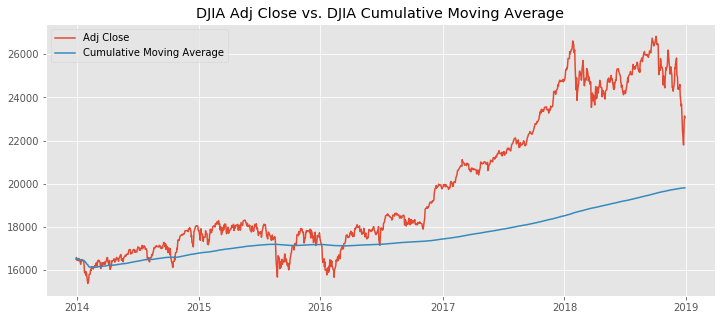

In [345]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(12,5))
    plt.plot(djia['Date'], djia['Adj Close'])
    plt.plot(djia['Date'], djia['Cumulative Moving Average'])
    plt.title('DJIA Adj Close vs. DJIA Cumulative Moving Average')
    plt.legend(loc='best')
    plt.show()

Now, as we said at the beginning of our project, the main assumption of the mean-reversion strategy could be summarised as the following: when the price moves "too far" from the mean, it is expected to go back (to "revert") to the mean.

To measure how far the price (of the DJIA) is from the mean (cumulative moving average), we will use z-scores. 
Simply put, a z-score is the number of standard deviations from the mean a data point is. Here's how it is computed:
 $$ z-score(x) = \frac{x - \mu}{\sigma} $$

In our example:
- x is the stock price (DJIA "adjusted close")
- µ is the cumulative moving average
- σ is the standard deviation of the stock price

A z-score of 1 (respectively -1) means that the price is one standard deviation above (respectively below) the mean.

Our trading strategy will be the following:
- When the z-score of a day rises above 1, we will short the DJIA index (as we expect it to go down, as stated by the mean-reversion strategy). We will keep our short position as long as the z-score stays above 1.
- When the z-score of a day decreases below -1, we will buy the DJIA index (as we expect it to go up). We will keep our long position as long as the z-score stays below -1.
- When the absolute value of the z-score falls below 1, we will close our position. Indeed, if we were long the index (z-score < -1) and the z-score then rose above -1 (but still below 1), we will close our position. Same thing if we were short the index (z-score > 1) and the z-score then fell below 1 (but still above -1).
- If the z-score crosses from below -1 to above 1 (or from above 1 to below -1) from one day to another, we will close our exisiting position and take the opposite position. For example, if the z-score crosses from -1.3 to 1.4, we will sell our share and sell another one to be short the stock (as we expect it to go down).

That way, on any day, we will always be:
- long the stock (the DJIA index) when the z-score is below -1
- short the stock when the z-score is above 1
- market neutral (no position) when the z-score is between -1 and 1 (i.e. abs(z-score) < 1)

Let's create a column "Z_score" and compute its values.

In [346]:
djia['Z_score']=np.zeros
djia.head()

,Date,Adj Close,Cumulative Moving Average,Z_score
0,2013-12-30,16504.29,16504.3,<built-in function zeros>
1,2013-12-31,16576.66,16540.5,<built-in function zeros>
2,2014-01-02,16441.35,16507.4,<built-in function zeros>
3,2014-01-03,16469.99,16498.1,<built-in function zeros>
4,2014-01-06,16425.10,16483.5,<built-in function zeros>


In [347]:
for i in range(len(djia)):
    djia['Z_score'][i] = (djia['Adj Close'][i] - djia['Cumulative Moving Average'][i]) / np.std(djia['Adj Close'][:i+1])

djia.head()

C:\Users\Jonathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


,Date,Adj Close,Cumulative Moving Average,Z_score
0,2013-12-30,16504.29,16504.3,NaN
1,2013-12-31,16576.66,16540.5,1
2,2014-01-02,16441.35,16507.4,-1.19533
3,2014-01-03,16469.99,16498.1,-0.555552
4,2014-01-06,16425.10,16483.5,-1.08477


Let's plot the z-scores over our time period.

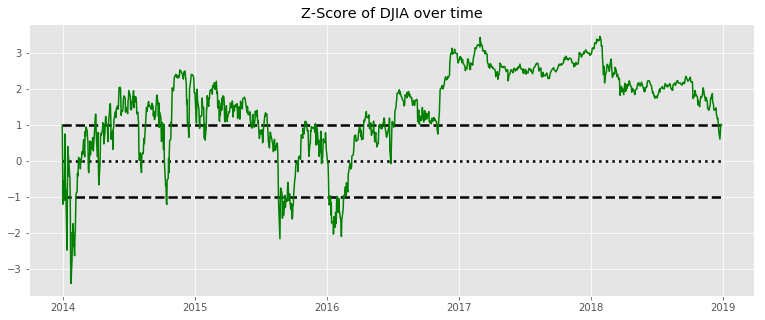

In [348]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(13,5))
    plt.plot(djia['Date'],djia['Z_score'],color='g')
    plt.title('Z-Score of DJIA over time')
    matplotlib.pyplot.hlines(0,'2013-12-30','2018-12-28',color='black', linewidth=2.5, linestyles='dotted')
    matplotlib.pyplot.hlines(1,'2013-12-30','2018-12-28',color='black', linewidth=2.5, linestyles='dashed')
    matplotlib.pyplot.hlines(-1,'2013-12-30','2018-12-28',color='black', linewidth=2.5, linestyles='dashed')

- When the z-score rises above 1 (dotted line), it is a sell signal.
- When the z-score falls below -1 (dotted line), it is a buy signal.
- When the absolute value of the z-score falls below 1, it is a signal that we should close our position.

Let's backtest this strategy. 

Let's start with no cash in our account (Balance = 0) and no position (Long / Short Position = 0).
We will compute them every day over our time period.

- Long / Short position = 1 <=> We are long the stock
- Long / Short position = -1 <=> We are short the stock
- Long / Short position = 0 <=> We have no position

In [349]:
djia['Balance']=0
djia['Long / Short Position']=0

for i in range(1,len(djia)):
    if djia['Z_score'][i-1]<-1:
        if djia['Z_score'][i]>1:
            djia['Balance'][i]=djia['Balance'][i-1]+2*djia['Adj Close'][i]
            djia['Long / Short Position'][i]=-1
        elif djia['Z_score'][i]<-1:
            #do nothing
            djia['Balance'][i]=djia['Balance'][i-1]
            djia['Long / Short Position'][i]=djia['Long / Short Position'][i-1]
        elif abs(djia['Z_score'][i])<=1:
            djia['Balance'][i]=djia['Balance'][i-1]+djia['Adj Close'][i]
            djia['Long / Short Position'][i]=0
    elif djia['Z_score'][i-1]>1:
        if djia['Z_score'][i]>1:
            #do nothing
            djia['Balance'][i]=djia['Balance'][i-1]
            djia['Long / Short Position'][i]=djia['Long / Short Position'][i-1]
        elif djia['Z_score'][i]<-1:
            djia['Balance'][i]=djia['Balance'][i-1]-2*djia['Adj Close'][i]
            djia['Long / Short Position'][i]=1
        elif abs(djia['Z_score'][i])<=1:
            djia['Balance'][i]=djia['Balance'][i-1]-djia['Adj Close'][i]
            djia['Long / Short Position'][i]=0
    elif abs(djia['Z_score'][i-1])<=1:
        if djia['Z_score'][i]>1:
            djia['Balance'][i]=djia['Balance'][i-1]+djia['Adj Close'][i]
            djia['Long / Short Position'][i]=-1
        elif djia['Z_score'][i]<-1:
            djia['Balance'][i]=djia['Balance'][i-1]-djia['Adj Close'][i]
            djia['Long / Short Position'][i]=1
        elif abs(djia['Z_score'][i])<=1:
            #do nothing
            djia['Balance'][i]=djia['Balance'][i-1]
            djia['Long / Short Position'][i]=djia['Long / Short Position'][i-1]
djia.tail()

,Date,Adj Close,Cumulative Moving Average,Z_score,Balance,Long / Short Position
1254,2018-12-21,22445.37,19796.2,0.814918,-15156,0
1255,2018-12-24,21792.20,19797.8,0.613655,-15156,0
1256,2018-12-26,22878.45,19800.3,0.947172,-15156,0
1257,2018-12-27,23138.82,19802.9,1.02645,7982,-1
1258,2018-12-28,23062.40,19805.5,1.00214,7982,-1


Therefore, with this strategy, over this time period, we would have ended up with $7,982. This is of course a big simplification of reality as we have assumed that we have no transaction costs for example.

Let's look at a statistics summary of our backtest. 

In [350]:
djia.describe()

,Adj Close,Balance,Long / Short Position
count,1259.00000,1259.000000,1259.000000
mean,19805.52143,-404.020651,-0.664813
std,3251.22440,10986.730502,0.568483
min,15372.80000,-32882.000000,-1.000000
25%,17280.28500,-11714.000000,-1.000000
50%,18128.66000,6194.000000,-1.000000
75%,22376.00000,7703.000000,0.000000
max,26828.39000,7982.000000,1.000000


As the Balance mean over the time period is negative, this strategy would on average make you lose money. Plus, the standard deviation is way higher than the mean.
Note that the median is positive ($6194) though.

A boxplot and a histogram of the balance help us see better the data.

Text(0.5, 0, 'Balance (in $)')

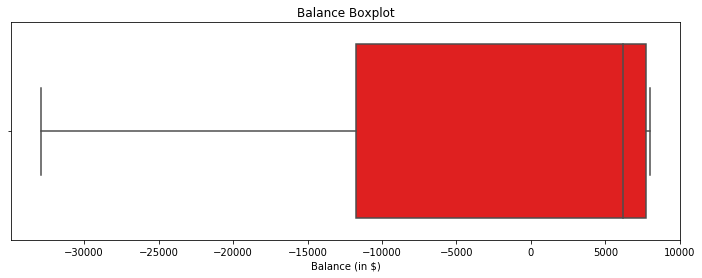

In [351]:
plt.figure(figsize=(12,4))
sns.boxplot(djia['Balance'], color='red')
plt.title('Balance Boxplot')
plt.xlabel('Balance (in $)')

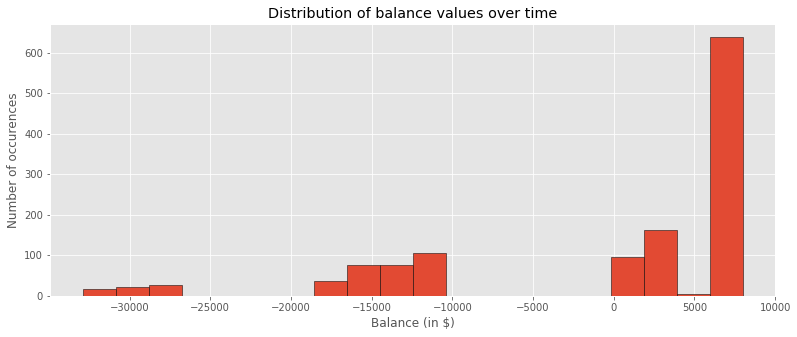

In [352]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(13,5))
    plt.hist(djia['Balance'],bins=20,edgecolor='black')
    plt.title('Distribution of balance values over time')
    plt.xlabel('Balance (in $)')
    plt.ylabel('Number of occurences')
    plt.show()

We have just backtested a mean-reversion trading strategy on a single stock.

Let's now see how we could implement a mean-reversion strategy on two stocks (pairs trading).

## Part II - Mean-reversion trading strategy on a stock pair

We will use the difference in the stock price of two stocks (the 'spread' from now on). Applying a mean reversion strategy would be to expect the 'spread' to go back to its mean. 

This assumption makes sense if the two stocks are cointegrated. Companies who provide very close products/services are generally cointegrated. They both react in approximately the same way to market and industry changes, i.e. their stock prices are in theory supposed to stay at a relatively constant spread. 

That's why we will study the stock prices of BNP Paribas and Société Générale (their business models are very close and they compete in almost all their business segments).

First, let's get the data of BNP and SG.

In [353]:
pairs = ['BNP.PA', 'GLE.PA']
df=yf.download(pairs,start=dt.datetime(2014,3,31), end=dt.datetime(2019,3,31))

bnp = df['Adj Close']['BNP.PA']
sg = df['Adj Close']['GLE.PA']

[*********************100%***********************]  2 of 2 downloaded


Let's then verify that those two stock prices are cointegrated by computing the p-value.

In [354]:
from statsmodels.tsa.stattools import coint
_, pvalue, _ = coint(bnp, sg)
pvalue

0.33085466184762513

As the p-value is low, the two stock prices are indeed cointegrated. Therefore, it makes sense to test this mean-reversion strategy.

Let's keep the "adjusted close" of BNP and SG (which we will use as their respective stock prices) and get rid of the irrelevant data.

In [355]:
df = df['Adj Close']
df.head()

,BNP.PA,GLE.PA
Date,,
2014-03-31,45.85,36.22
2014-04-01,47.08,37.81
2014-04-02,47.47,37.95
2014-04-03,48.00,38.39
2014-04-04,48.62,38.60


Let's see how correlated the two stock prices are.

In [356]:
correlation=df.corr().round(2)
correlation

,BNP.PA,GLE.PA
BNP.PA,1.00,0.94
GLE.PA,0.94,1.00


A scatterplot of the two stock prices and a simple linear regression make this correlation obvious.

Estimated regression coefficients:
b_0 = 2.081224899048223
b_1 = 0.6891959473539091


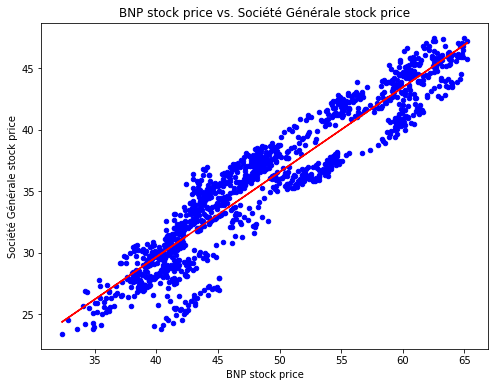

In [357]:
x = np.array(bnp).reshape(-1,1) 
y = np.array(sg).reshape(-1,1)
b = estimate_coef(x, y) 
print("Estimated regression coefficients:\nb_0 = {}\
\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b)
plt.title('BNP stock price vs. Société Générale stock price')
plt.xlabel('BNP stock price')
plt.ylabel('Société Générale stock price')

def estimate_coef(x, y): 
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, color = "b", marker = "o", s = 5)  
    y_pred = b[0] + b[1]*x 
    plt.plot(x, y_pred, color = "r")
    plt.xlabel('x') 
    plt.ylabel('y') 

In Part I with the single stock, we computed the cumulative moving average of the stock price.

We will now compute the daily 'spread' (BNP stock price - SG stock price) and the cumulative moving average of the 'spread'.

In [358]:
spread_strategy = pd.DataFrame(index = bnp.index, columns=['Spread','CMA'])
spread_strategy['Spread'] = bnp - sg
spread_strategy['CMA']= [spread_strategy['Spread'][:i+1].mean() for i in range(len(spread_strategy['Spread']))]

Let's see how they look like.

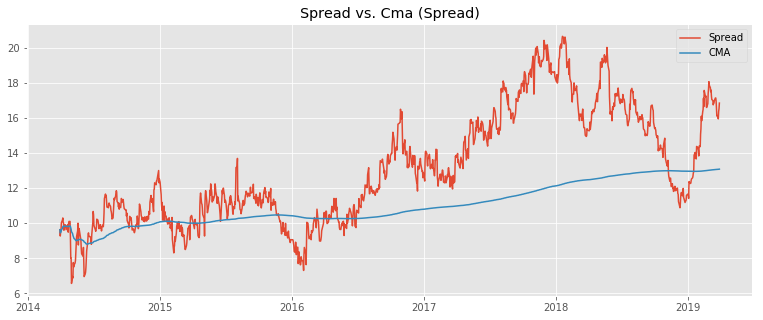

In [359]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(13,5))
    plt.plot(spread_strategy['Spread'])
    plt.plot(spread_strategy['CMA'])
    plt.title('Spread vs. Cma (Spread)')
    plt.legend(loc='best')
    plt.show()

In [360]:
spread_strategy.head().round(2)

,Spread,CMA
Date,,
2014-03-31,9.63,9.63
2014-04-01,9.27,9.45
2014-04-02,9.52,9.47
2014-04-03,9.61,9.51
2014-04-04,10.02,9.61


_In exactly the same way as Part I (with a single stock)_, let's compute the daily z-scores of the 'spread' over our time period.

In [361]:
spread_strategy['Z_score']=np.zeros

pd.options.mode.chained_assignment = None  # default='warn'

for i in range(len(spread_strategy)):
    spread_strategy['Z_score'][i] = (spread_strategy['Spread'][i] - spread_strategy['CMA'][i]) / np.std(spread_strategy['Spread'][:i+1])

spread_strategy.head()

C:\Users\Jonathan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,Spread,CMA,Z_score
Date,,,
2014-03-31,9.63,9.630000,NaN
2014-04-01,9.27,9.450000,-1
2014-04-02,9.52,9.473333,0.309813
2014-04-03,9.61,9.507500,0.715564
2014-04-04,10.02,9.610000,1.69601


In [362]:
spread_strategy['Balance']=0
spread_strategy['Long / Short Position']=0

for i in range(1,len(spread_strategy)):
    if spread_strategy['Z_score'][i-1]<-1:
        if spread_strategy['Z_score'][i]>1:
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]+2*spread_strategy['Spread'][i]
            spread_strategy['Long / Short Position'][i]=-1
        elif spread_strategy['Z_score'][i]<-1:
            #do nothing
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]
            spread_strategy['Long / Short Position'][i]=spread_strategy['Long / Short Position'][i-1]
        elif abs(spread_strategy['Z_score'][i])<=1:
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]+spread_strategy['Spread'][i]
            spread_strategy['Long / Short Position'][i]=0
    elif spread_strategy['Z_score'][i-1]>1:
        if spread_strategy['Z_score'][i]>1:
            #do nothing
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]
            spread_strategy['Long / Short Position'][i]=spread_strategy['Long / Short Position'][i-1]
        elif spread_strategy['Z_score'][i]<-1:
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]-2*spread_strategy['Spread'][i]
            spread_strategy['Long / Short Position'][i]=1
        elif abs(spread_strategy['Z_score'][i])<=1:
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]-spread_strategy['Spread'][i]
            spread_strategy['Long / Short Position'][i]=0
    elif abs(spread_strategy['Z_score'][i-1])<=1:
        if spread_strategy['Z_score'][i]>1:
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]+spread_strategy['Spread'][i]
            spread_strategy['Long / Short Position'][i]=-1
        elif spread_strategy['Z_score'][i]<-1:
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]-spread_strategy['Spread'][i]
            spread_strategy['Long / Short Position'][i]=1
        elif abs(spread_strategy['Z_score'][i])<=1:
            #do nothing
            spread_strategy['Balance'][i]=spread_strategy['Balance'][i-1]
            spread_strategy['Long / Short Position'][i]=spread_strategy['Long / Short Position'][i-1]
spread_strategy.tail()

,Spread,CMA,Z_score,Balance,Long / Short Position
Date,,,,,
2019-03-25,16.13,13.067820,0.958892,0,0
2019-03-26,15.94,13.070071,0.898758,0,0
2019-03-27,16.36,13.072647,1.02946,16,-1
2019-03-28,16.52,13.075344,1.07865,16,-1
2019-03-29,16.84,13.078288,1.17775,16,-1


With this strategy applied over our time period, we would have ended with $16.

As for Part I, we should of course be careful not to infer too much from this result as the purpose of this backtest (as well as the backtest in Part I) is to show how to implement a mean-reversion strategy, not necessarily a profitable one.

Let's look at the daily z-scores over our time period.

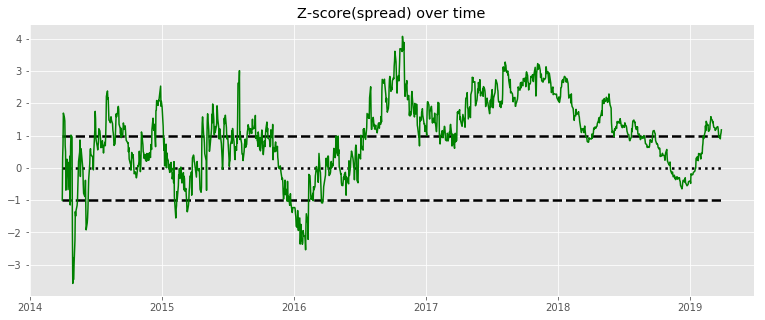

In [363]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(13,5))
    plt.plot(spread_strategy['Z_score'],color='g')
    plt.title('Z-score(spread) over time')
    matplotlib.pyplot.hlines(0,'2014-03-31','2019-03-29',color='black', linewidth=2.5, linestyles='dotted')
    matplotlib.pyplot.hlines(1,'2014-03-31','2019-03-29',color='black', linewidth=2.5, linestyles='dashed')
    matplotlib.pyplot.hlines(-1,'2014-03-31','2019-03-29',color='black', linewidth=2.5, linestyles='dashed')

Let's look at a statistics summary of our backtest.

In [364]:
spread_strategy.describe()

,Spread,CMA,Balance,Long / Short Position
count,1279.000000,1279.000000,1279.000000,1279.000000
mean,13.078288,10.999935,6.218921,-0.469898
std,3.195232,1.186984,6.902105,0.595097
min,6.570000,8.812264,-9.000000,-1.000000
25%,10.460000,10.193929,0.000000,-1.000000
50%,12.220000,10.471408,10.000000,-1.000000
75%,15.760000,12.110561,13.000000,0.000000
max,20.640000,13.078288,16.000000,1.000000


The mean of the daily balances are positive ($6.22) but the standard deviation of the balance is even slightly bigger than the mean. The median is also positive.

A boxplot and a histogram will help us see the data in a more concrete manner.

Text(0.5, 0, 'Balance (in $)')

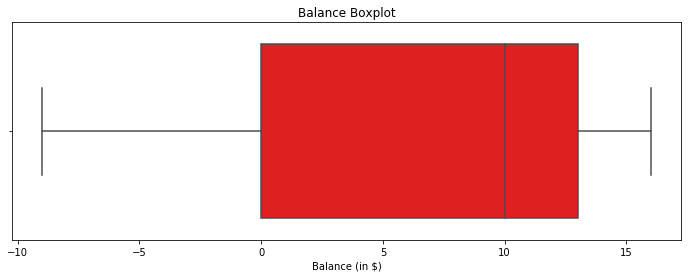

In [365]:
plt.figure(figsize=(12,4))
sns.boxplot(spread_strategy['Balance'], color='red')
plt.title('Balance Boxplot')
plt.xlabel('Balance (in $)')

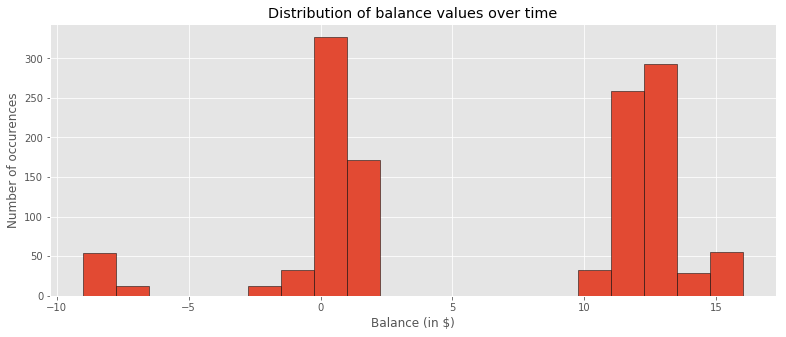

In [366]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(13,5))
    plt.hist(spread_strategy['Balance'],bins=20,edgecolor='black')
    plt.title('Distribution of balance values over time')
    plt.xlabel('Balance (in $)')
    plt.ylabel('Number of occurences')
    plt.show()

Now that we've looked at how we could implement a mean-reversion trading strategy on a single stock (Part I) and on a pair of stocks (Part 2), we will finish by implementing a mean-reversions strategy on a portfolio / basket of stocks.

## Part III - Mean-reversion trading strategy on a portfolio of stocks

Let's consider 10 stocks (arbitrary number and arbitrary stocks) as our investment universe. 

Our goal is to make up a portfolio of stocks (that are part of our investment universe) via a mean-reversion strategy. 

We could do what we did in Part I, i.e. go long / short / neutral on each stock of the investment universe depending on their z-scores.

But, if we assume that mean-reversion is real and thus the stocks that are the farthest from their mean will approximately go back to their mean, that method will not be efficient as the one we are going to use: 
- go long on the stocks that had the worst returns among the stocks of the investment universe up to now

The underlying idea is that by selecting the stocks that had the worst returns, we are selecting the stocks that have the most upside potential according to mean-reversion philosophy.
- go short on the stocks that had the best returns among the stocks of the investment universe up to now

Likewise, by selecting the stocks that had the best returns, we are selecting the stocks that have the most downside potential.
- go neutral on the rest of the stocks of the investment universe


Here's our investment universe (10 randomly chosen stocks):
- AAPL (Apple)
- JP (JP Morgan Chase & Co.)
- NFLX (Netflix)
- INTC (Intel)
- SBUX (Starbucks)
- SAN.PA (Sanofi)
- BLK (Blackrock)
- XOM (Exxon Mobil)
- KO (Coca-Cola)
- F (Ford Motor)

Let's get the data for these 10 stocks from Yahoo Finance.

In [367]:
stocks = ['AAPL', 'JP', 'NFLX', 'INTC','SBUX', 'SAN.PA', 'BLK', 'XOM', 'KO', 'F']
stocks.sort()
df=yf.download(stocks,start=dt.datetime(2019,3,1), end=dt.datetime(2019,3,31))

[*********************100%***********************]  10 of 10 downloaded


Let's store the relevant price data in a dataframe called "prices" and compute the daily returns of these 10 stocks over our time period.

In [368]:
prices=df['Adj Close']
returns=prices/prices.shift(-1)-1

Let's plot the daily returns over our time period.

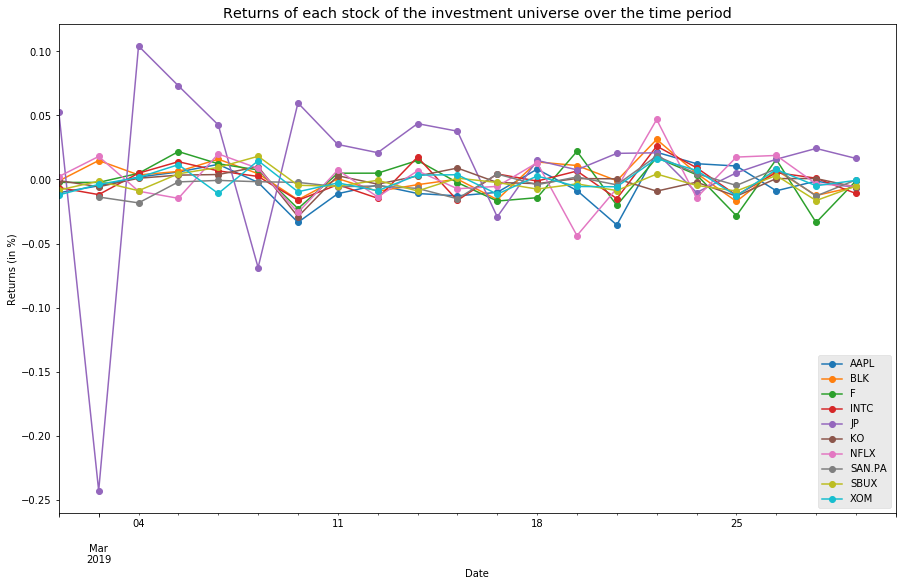

In [369]:
returns.plot(figsize=(15,9), marker='o')
with plt.style.context('ggplot'):
    plt.legend(loc=4)
    plt.title("Returns of each stock of the investment universe over the time period")
    plt.ylabel('Returns (in %)')

Let's get rid of the first day so that we start at the beginning of the month.

In [370]:
prices = prices.iloc[1:]
prices.head()

,AAPL,BLK,F,INTC,JP,KO,NFLX,SAN.PA,SBUX,XOM
Date,,,,,,,,,,
2019-03-01,174.97,440.42,8.50,53.30,4.18,44.99,357.32,74.00,70.85,80.00
2019-03-04,175.85,434.03,8.52,53.94,5.52,45.25,351.04,75.03,70.95,80.31
2019-03-05,175.53,432.52,8.48,53.68,5.00,45.21,354.30,76.43,71.58,80.19
2019-03-06,174.52,429.86,8.30,52.95,4.66,45.06,359.61,76.58,71.27,79.28
2019-03-07,172.50,423.19,8.20,52.60,4.47,44.89,352.60,76.64,70.61,80.16


Let's convert our dataframe into a numpy array so that we can do operations more easily.

In [371]:
prices = np.array(prices)

*Here's what our mean-reversion strategy looks like:*

1 - We compute the return of each of these 10 stocks over a sub-period of our time period (we chose a sub-period equal to the first week of our  time period).

2 - We compute the return of each of these 10 stocks over the remaining time period (the rest of the month of March 2019).

3 - We make up *our portfolio* with :
- long positions in the two stocks which had the worst returns (out of the 10 stocks) over the sub-period (i.e. over the first week) as we expect them to go up over the remaining time period.
- short positions in the two stocks which had the best returns (out of the 10 stocks) over the sub-period (i.e. over the first week) as we expect them to go down over the remaining time period.

4 - We compute the yield of our strategy over our investment time period (i.e. from the end of the first week of March to the end of March).

Let's first compute the 10 returns of the first week (first_week_returns) and order the stocks by ascending returns (order).

In [372]:
first_week_returns = (prices[4] - prices[0])/prices[0]
order = first_week_returns.argsort() 
rank = order.argsort()

In [373]:
first_week_returns

array([-0.01411671, -0.03912175, -0.03529412, -0.01313321,  0.06937799,
       -0.00222272, -0.01320945,  0.03567568, -0.00338744,  0.002     ])

In [374]:
order

array([1, 2, 0, 6, 3, 8, 5, 9, 7, 4], dtype=int64)

The first element of 'order' (Blackrock) had the lowest return (-0.03912175) over the first week. The second element (Ford) had the second lowest return, and so on.

In [375]:
rank

array([2, 0, 1, 4, 9, 6, 3, 8, 5, 7], dtype=int64)

We can see that Blackrock (0 in 'rank') had the lower return over the first week, followed by Ford (1 in 'rank').

Let's compute the return of each of the stocks for the remaining time period and order the stocks by ascending returns (order2).

In [376]:
rest_of_the_month_returns = (prices[-1] - prices[5])/prices[5]
order2 = rest_of_the_month_returns.argsort()

Let's plot the returns of the first week against the returns over the remaining period for those 10 stocks (with a regression line).

Estimated coefficients:
b_0 = 0.012743626528622381
b_1 = -2.14864625410196


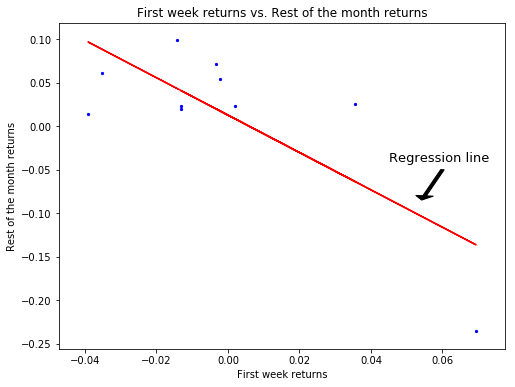

In [377]:
x = np.array([first_week_returns]).reshape(-1,1) 
y = np.array([rest_of_the_month_returns]).reshape(-1,1)
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\
\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b)
plt.title('First week returns vs. Rest of the month returns')
plt.xlabel('First week returns')
plt.ylabel('Rest of the month returns')
plt.arrow(0.06,-0.05, -0.005,-0.03,head_width=0.005, head_length=0.005,color='black')
plt.text(0.045,-0.04,'Regression line',size=13)

def estimate_coef(x, y): 
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, color = "blue", marker = "o", s = 20) 
    y_pred = b[0] + b[1]*x 
    plt.plot(x, y_pred, color = "r")
    plt.xlabel('x') 
    plt.ylabel('y') 

The correlation between the returns over the first week (sub_sample) and the returns over the rest of the month (remaining period) is significantly negative.

This negative correlation is in line with the philosophy of the mean-reversion strategy that we are going to use: 
- the lowest returns over the first week (negative returns) are among the highest for the rest of the month (positive returns)
- the highest returns over the first week (positive returns) are among the lowest for the rest of the month (negative returns)

At the end of the first week, we choose to:
- go long on the two stocks which had the lowest returns over the first week
- go short on the two stocks which had the highest returns over the first week


We then compute the yield of our strategy over the investment time period.

In [378]:
long_positions = np.array([int(x <= 1) for x in rank])
short_positions = np.array([int(x >= 8) for x in rank])

for i in range(len(longs)):
    if long_positions[i]==1:
        print('Long position in:', stocks[i])
for i in range(len(shorts)):
    if short_positions[i]==1:
        print('Short position in:', stocks[i])
        
print('We get a yield of: $', sum((prices[-1] - prices[4])*(long_positions - short_positions)).round(2))

Long position in: BLK
Long position in: F
Short position in: JP
Short position in: SAN.PA
We get a yield of: $ 3.32


With this strategy, i.e. buy BLK & F and short JP & SAN.PA at the end of the first week, we would get a yield of $3.32 over the rest of the month.

To conclude, we have just seen several ways to apply a mean-reversion trading strategy, first to a single stock, then to a pair of stocks, and finally to select stocks from an investment universe. Different versions of these strategies could of course be used. 

A goal of this project was to take different perspectives (for example a trader who trades a specific stock or a pair - Part I / Part II) and see what mean-reversion strategies could be implemented. In Part III, we could see the investment universe as a constraint for a trader (who has to choose stocks in this investment universe), which adds a dimension complexity to our analysis.